<a href="https://colab.research.google.com/github/dotdigital26/Covid-19-Topic-Modelling/blob/main/LDP_Covid_19_Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using NLP to Fish Out Topics from Scrapped Covid-19 tweets

Sifting through a deep sea of tweets to fish out topics is a hard problem and humanly challenging to achieve. In this project, we will see how to apply Topic Modeling (NLP technique) to solve this problem.

Before going into the problem statement, let’s briefly talk about Topic Modeling.

# Topic Search Model based on Latent Dirichlet Allocation (LDA)
What's Topic Modeling ?

Topic modelling can be described as a method for finding a group of words (i.e. a topic) from a collection of documents (a "corpus") that best represents the information in the collection. Automatically extracting context from large corpuses of data and dividing them into topics for further drill down is a major application of Natural Language Processing.

# Project summary:




*   Build an LDA model that learns N topics (optimum value for N calculated programmatically) from the tweets
*   Analyze the topic clusters, see if the topic clustering makes sense
*   Plot the TSNE to see if the topics cluster looks segregated enough





In [ ]:
!pip install pyLDAvis
!pip install nltk

     |████████████████████████████████| 1.6MB 4.7MB/s 
     |████████████████████████████████| 552kB 24.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=3ea301dec20f3e36820e3290bbb753ef6e077d291e7c84c9519ab54bdb3d83bd
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=9a1403fb770f7868baf5774aea873d3c45f03775b86740c245a184aa5f292cad
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [ ]:
#Import libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 1000)

from IPython.display import display, HTML
display(HTML(data="""
<style>
   div#notebook-container    { width: 95%; }
   div#menubar-container     { width: 95%; }
   div#maintoolbar-container { width: 99%; }
</style>
"""))

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Upload the Dataset exported as excel known as xlxs

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Outside spaces raw SM data.xlsx to Outside spaces raw SM data.xlsx


# Lets have a look at the dimension/size of the data

In [ ]:

raw_data = pd.read_excel('Outside spaces raw SM data.xlsx')
raw_data.shape

(18910, 45)

# How does the data look ?


> Since, we're dealing with raw tweets, the only variable we need is 'Content', and we have just displayed the first 5 and the last 5 rows



In [ ]:
raw_data['content'].head()

0        important information    golf in scotland ...
1    if your feeling stressed do you hit the golf c...
2    in relation to coronavirus  covid      we are ...
3    we ve seen lots of posts about the current sit...
4    experiencing stress  anxiety and low moods fro...
Name: content, dtype: object

In [ ]:
#raw_data=raw_data.drop_duplicates('content')

raw_data=raw_data.drop(['id', 'search', 'source', 'application', 'title', 'content', 'date', 'parent', 'language', 'url', 'parent source identifier', 'domain', 'image tags', 'tags', 'sentiment', 'sentiment class', 'sentiment by', 'main emotion', 'emotions', 'visibility', 'potential impressions', 'actual impressions', 'city', 'country', 'latitude', 'longitude', 'user city', 'user country', 'user latitude', 'user longitude', 'no. of followers', 'no. of friends', 'gender', 'bio', 'links url', 'no. of comments', 'no. of likes', 'no. of shares', 'no. of retweets', 'user name', 'user screen name', 'user source id', 'eRep', 'intensity'], axis=1) 

In [ ]:
raw_data['content'].tail()

18905    Really wanna go for a walk around Fletcher Mos...
18906    RT @p_longfootphoto: Went for a walk in Newsha...
18907    RT @LEOacademies: Today's online lessons for Y...
18908    RT @p_longfootphoto: Went for a walk in Newsha...
18909    @Humfthecocker @Amadeusivan @harveycusick @Lou...
Name: content, dtype: object

# NLP preprocessing data

In [ ]:
# NLTK Stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(["for",'may','want','also','still','know','get','get', 'back', 'desk', 'find','see','make','sure',
                   'other','rather','would','mean','ok','must','part','hence','show','un',"co",'http','zzsh','lijixqmvmp','want','instead','ever','allow','almost','else','let','put','co','diy','flpcsqlsc'])

# Convert to list
data = raw_data.content.values.tolist()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#I have managed to convert each tweets into list, separated by commas - now you can read what people are saying
data[6:10]

['imagine a very fit and healthy me off out to local pub local band couple pints of guinness we t for a pee hardly any action didn t think much of it couple more pints band finishes get back home to my cave total body shutdown no pee no doo awake all nite total shut down called   wanted to get ambulance to me but being me there s always somebody worse off than myself went waiting outside local doc waited there for them to say we do do cafiters go so and so of i went doubled up called friendgot a litt was going to burst from inside out by this time  hardly anyone in a e straight in creased up totally by this time one tube in didn t work doc says that s weired the didn t have next size in stock put small tube in wow the world could be mine again  wanted to check for cancer nope i m out of here with cafitar and bag but least i didn t pop open    days later got appointment to get it out and another to put it back in if i didn t work   got it out then had to train bladder to work proper aga

# Data Cleaning Continues


> We will create a function that would perform the following operations as most tweets are ridden of dirts, so we got to clean them up and make tweets more readable!

*   remove_URL
*   Remove stopwords 
*   Remove duplicate words
*   Convert uppercase to lower
*   Remove punctuations, ascii codes etc







In [ ]:
##URL REMOVAL
##Uppercase to lower
##removal of unecessary symbols

raw_data['content']=raw_data['content'].replace(r'http\S+@','',regex=True).replace(r'www\S+',regex=True)
def extract_hashtag(tweets):
    tweets = re.sub('[^a-zA-Z]',' ',tweets)
    tweets = tweets.lower()
    return tweets

raw_data['content']=raw_data.content.apply(extract_hashtag)


In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[3]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


# Let us define some more functions here and call them when we need them

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# We would now need to call our functions to perform operations

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1])

In [ ]:
##Dealing  with some stopwords. Words like 'may,still,get,find,hence,want' which do not add adding meaning to our model, so we'd like to remove them
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

stop_words.extend(["for",'may','want','also','still','know','get','get', 'back', 'desk', 'find','see','make','sure',
                   'other','rather','would','mean','ok','must','part','hence','show','un',"co",'http','zzsh','lijixqmvmp','want','instead','ever','allow','almost','else','let','put','co','diy','flpcsqlsc'])

data_words_nostops = remove_stopwords(data_words)

In [ ]:
###Take a look at all the tweets lemmatized(converted to their base form)

In [ ]:
print(data_lemmatized)

[['important', 'information', 'golf', 'aware', 'current', 'scottish', 'government', 'continue', 'life', 'symptom', 'request', 'day', 'mass', 'gathering', 'cancel', 'help', 'go', 'ahead', 'schedule', 'event', 'include', 'positive', 'event', 'golfer', 'turnberry', 'maximum', 'master', 'scramble', 'risk', 'virus', 'spread', 'area', 'low', 'good', 'health', 'benefit', 'go', 'week', 'start', 'next', 'week', 'case', 'rise', 'update', 'government', 'change', 'time', 'full', 'steam', 'ahead', 'precaution', 'symptom', 'relate', 'attend', 'government', 'advice', 'point', 'end', 'positive', 'weather', 'forecast', 'look', 'spring', 'arrive', 'hopefully', 'chance', 'play', 'golf', 'try', 'respond', 'individual', 'email', 'friend', 'play', 'event', 'please'], ['feel', 'stress', 'hit', 'relieve', 'stress', 'help', 'actually', 'boost', 'immune_system', 'well', 'put', 'close_proximity', 'lot', 'people', 'good', 'nature', 'help', 'well', 'escape', 'book', 'tee', 'time'], ['relation', 'advise', 'consulta

In [ ]:
#I create a dictionary of the words in the tweets..this is used to determine the size of the vocabulary, 
# topic classification. Also, note that the two main input in our topic model are id2word and corpus. So let's create them
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[('advice', 1),
  ('ahead', 2),
  ('area', 1),
  ('arrive', 1),
  ('attend', 1),
  ('aware', 1),
  ('benefit', 1),
  ('cancel', 1),
  ('case', 1),
  ('chance', 1),
  ('change', 1),
  ('continue', 1),
  ('current', 1),
  ('day', 1),
  ('email', 1),
  ('end', 1),
  ('event', 3),
  ('forecast', 1),
  ('friend', 1),
  ('full', 1),
  ('gathering', 1),
  ('go', 2),
  ('golf', 2),
  ('golfer', 1),
  ('good', 1),
  ('government', 3),
  ('health', 1),
  ('help', 1),
  ('hopefully', 1),
  ('important', 1),
  ('include', 1),
  ('individual', 1),
  ('information', 1),
  ('life', 1),
  ('look', 1),
  ('low', 1),
  ('mass', 1),
  ('master', 1),
  ('maximum', 1),
  ('next', 1),
  ('play', 2),
  ('please', 1),
  ('point', 1),
  ('positive', 2),
  ('precaution', 1),
  ('relate', 1),
  ('request', 1),
  ('respond', 1),
  ('rise', 1),
  ('risk', 1),
  ('schedule', 1),
  ('scottish', 1),
  ('scramble', 1),
  ('spread', 1),
  ('spring', 1),
  ('start', 1),
  ('steam', 1),
  ('symptom', 2),
  ('time', 1),


In [ ]:
len(corpus)

10183

# Run multiple LDA models with different N topics to find the best N-topic model

#Compute coherence score for mulitple 'N' number of topics to find the optimum number


In [ ]:
%%time
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 8.58 µs


In [ ]:
%%time
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=3, limit=20, step=1)

CPU times: user 13min 24s, sys: 4.46 s, total: 13min 28s
Wall time: 13min 29s


# Plot the coherence scores for different N topics
# Select optimum N with coherence scores

Traditionally, to select the best and optimal topic eyeballing and implicit knowledge are used in many pratical application of topic modelling. But in our case, we would capture our model in metrics called **Coherence Metric**



>Coherence score measures the relative distance between words within a topic. The overall coherence score of a topic is the average of the distances between words. Coherence score typically ranges between 0 < x < 1. The higher the score similar the words contained in a topic.However,it almost impossible to see a coherence score of 1 or .8+ unless the word measured are perfectly identical. By identical, I meant to say (United and States, United and Kingdom, County and council etc).  





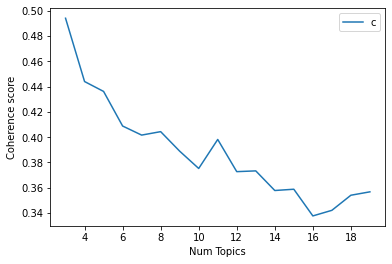

In [ ]:
#@title Default title text
## Plot the coherence scores for different N topics
### Select optimum N

# Show graph
limit=20; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

*The coherence score seems to keep decreasing as the number of topic increases.That is the higher the score the smaller the topic. This sort of makes a intuitive sense and this happen in an event where topics are too similar to one another, which tend to overlap and almost difficult of distinguish. One possible cause could be that people's activities during lockdown do not vary significantly - not changing. In any case, we would go for 12 topics, which is digestible for most humans.*

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

Num Topics = 3  has Coherence Value of 0.494
Num Topics = 4  has Coherence Value of 0.444
Num Topics = 5  has Coherence Value of 0.436
Num Topics = 6  has Coherence Value of 0.409
Num Topics = 7  has Coherence Value of 0.402
Num Topics = 8  has Coherence Value of 0.404
Num Topics = 9  has Coherence Value of 0.389
Num Topics = 10  has Coherence Value of 0.375
Num Topics = 11  has Coherence Value of 0.398
Num Topics = 12  has Coherence Value of 0.373
Num Topics = 13  has Coherence Value of 0.373
Num Topics = 14  has Coherence Value of 0.358
Num Topics = 15  has Coherence Value of 0.359
Num Topics = 16  has Coherence Value of 0.338
Num Topics = 17  has Coherence Value of 0.342
Num Topics = 18  has Coherence Value of 0.354
Num Topics = 19  has Coherence Value of 0.357




# Model selection: Let's see how the model with 12 topics looks like
Since the coherence score 0.37, looks like the rough average among the coherence scores of models tested so far. (You can play around with different models to see how the topics vary)
The topics would differ as we add more data and people's engagement/activities differ significantly.
> Indented block



In [ ]:
#max_index = max(enumerate(coherence_values),key=lambda x: x[1])[0]

# Select the model and print the topics
#optimal_model = model_list[max_index]
optimal_model = model_list[9]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))

[(0,
  '0.064*"lockdown" + 0.025*"turn" + 0.018*"top" + 0.017*"face" + '
  '0.017*"nature" + 0.016*"care" + 0.014*"level" + 0.014*"rest" + '
  '0.014*"experience" + 0.013*"reveal" + 0.013*"appear" + 0.012*"absolutely" + '
  '0.012*"hit" + 0.012*"social" + 0.011*"age" + 0.010*"comment" + '
  '0.010*"claim" + 0.009*"city" + 0.009*"stress" + 0.009*"announce" + '
  '0.008*"mate" + 0.008*"mask" + 0.008*"lie" + 0.008*"fit" + 0.007*"deal" + '
  '0.007*"sort" + 0.007*"struggle" + 0.007*"funny" + 0.006*"several" + '
  '0.006*"ride"'),
 (1,
  '0.042*"give" + 0.024*"away" + 0.023*"mile" + 0.022*"lovely" + '
  '0.021*"picture" + 0.017*"hill" + 0.016*"fan" + 0.014*"size" + 0.014*"boy" + '
  '0.014*"black" + 0.013*"better" + 0.012*"white" + 0.011*"tomorrow" + '
  '0.011*"son" + 0.010*"road" + 0.010*"matter" + 0.010*"football" + '
  '0.009*"bubble" + 0.009*"choose" + 0.009*"real" + 0.009*"sometimes" + '
  '0.009*"definitely" + 0.008*"kind" + 0.008*"everywhere" + 0.008*"literally" '
  '+ 0.007*"fantas

# Word cloud for Top words in Each topic
This is where the fun begins...each topic is represented as a word cloud. I have size of the keywords in the plot to be proportional to its weightage.



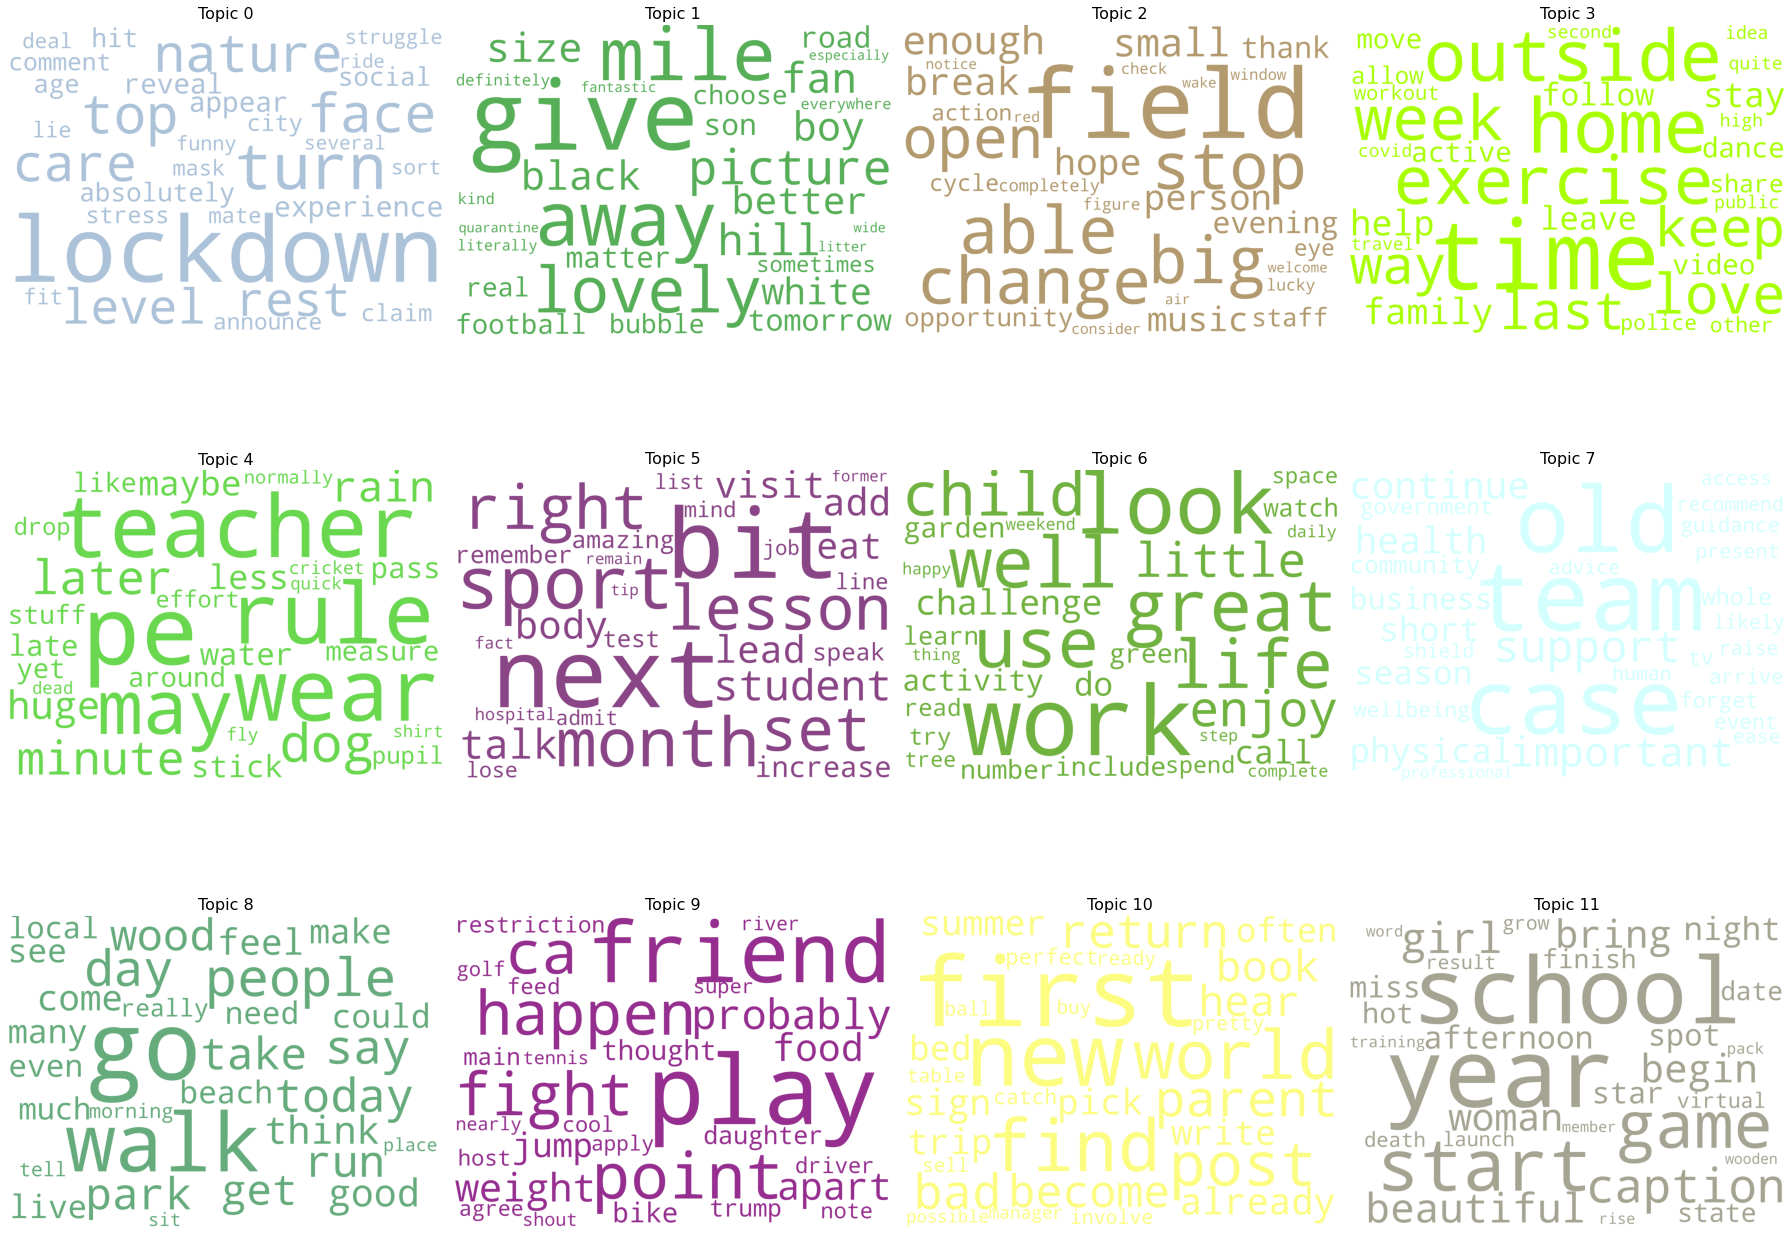

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'


cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='paired',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=30, num_words=30)
topics.sort(key=lambda tup: tup[0])

fig, axes = plt.subplots(3, 4, figsize=(25,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=550)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
topics

# TSNE Clustering

TSNE (t-Distributed Stochastic Neighbor Embedding) is an amazing technique of dimensionatily reduction that can be used for visualizing high-dimensional datasets.

In this case,we reduce the raw data to 2 dimensions and plot it by different topics. The topic segregation should be very interesting - meaning if the topics are well-segregated, we will see clearly distiguishable clusters (Hover over it to find out what is the data point)

In [ ]:
%%time
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
#arr = pd.DataFrame(topic_weights).fillna(0).values

#Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

CPU times: user 1min 14s, sys: 447 ms, total: 1min 15s
Wall time: 43.1 s


In [ ]:
import plotly.express as px
import plotly.graph_objects as go


tsne_lda_df = pd.DataFrame(tsne_lda)
tsne_lda_df.columns = ['col1', 'col2']
tsne_lda_df['topic'] = df_dominant_topic['Dominant_Topic']
raw_data = raw_data.reset_index(drop=True)
#tsne_lda_df['label'] = raw_data['label']
tsne_lda_df['content'] = raw_data['content']

tsne_lda_df['topic'] = tsne_lda_df['topic'].astype('object')

plt.set_cmap('tab20')
fig = px.scatter(tsne_lda_df, x='col1', y='col2', hover_name='content',
              color='topic',
#              facet_col='topic', 
               color_discrete_sequence=px.colors.carto.Bold)
#                  color_discrete_map={"0": "blue", "1": "green", "2":"red", "3":"yellow", "4":"magenta", "5":"cyan",
#                                    "6":"deepskyblue", "7":"lightcoral", "8":"darkorange", "9":"aquamarine",
#                                     "10":"peru", "11":"darkkhaki"})

fig.update_layout(
    title=go.layout.Title(
        text="TSNE representation of tweets segregated by topics",
        xref="paper",
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="TSNE Dim 1",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="TSNE Dim 2",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    )
)

fig.show()
#fig.write_html(r'LDP_TSNE.html')


<Figure size 432x288 with 0 Axes>

Quite interesting! Topic 8 seems to be the dominant topic. Overshaddowing every other topic in the topic set.

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, sort_topics=True)
pyLDAvis.save_html(vis,'LDP.html' )

# Conclusion
Our results were just as expected. Since the keywords or hastag of collected tweets are alike and incomprehesible(park,beach and wood). The distance between most topics are so small, as topic centers around people engaging in similar activities such as walking, sitting and running to the park, wood or the beach. 

For future analysis, the performance of our model would be enhanced if dataset contains tweets of more varied events or activities. In this case, the distance between topics would grow farther and we would have less overlapping topics 


# Departing thoughts
Topic models can be useful especially in extracting context from large document of data and divide them into manageable subsets for further analysis. 
 This tool could prove handy when we want to sift through large data set to get an idea as to whats going on -  which could be humanly tiring and challenging to achieve. The models can also get better as the dataset increases in size.

In [ ]:
from google.colab import files

files.download('LDP.html')